In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
# import os

# os.getcwd() # cur dir check

In [4]:
df = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')

In [5]:
# homework section

# q1
# df.info() #--> 19 cols

# q2
# x_df = df.copy()
# x_df['duration'] = x_df.tpep_dropoff_datetime - x_df.tpep_pickup_datetime
# x_df.duration = x_df.duration.apply(lambda td: td.total_seconds() / 60)
# x_df.describe() # answ: 46.45

# q3
# x_df = x_df[(x_df.duration >= 1) & (x_df.duration <= 60)]
# x_df.info() # --> 98% left

In [6]:

# df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime # to fit yellow cab data columns
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)] # convert duration to minutes

# setting them variables to cateterical ones
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
# to setup the general and method of the model

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.001496179445599

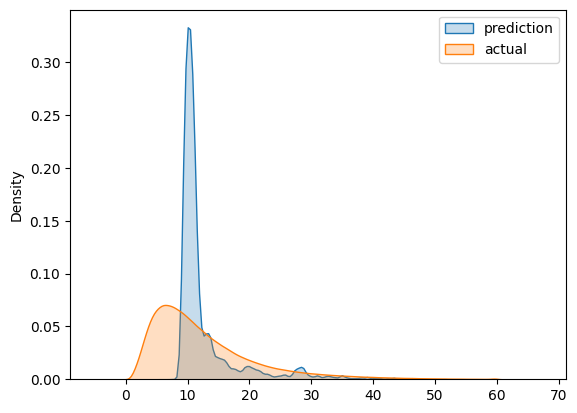

In [8]:
# fig = sns.displot(y_pred, label='prediction')
# fig = sns.displot(y_train, label='actual')

# plt.legend()

fig = sns.kdeplot(y_pred, label='prediction', fill=True)
fig = sns.kdeplot(y_train, label='actual', fill=True)

plt.legend()
plt.show()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    # df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime # adjustment for yellow cabs
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
# green cabs
# df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
# df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

# yellow cabs
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [11]:
len(df_train), len(df_val)

(2421440, 2918187)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
# df_train['PU_DO']

In [31]:
# categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [32]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

print(f"LR Train set error: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"LR Validation set error: {mean_squared_error(y_val, y_pred_val, squared=False)}")

LR Train set error: 7.001496179445599
LR Validation set error: 7.795498122351478


In [34]:
# with categorical = ['PU_DO']
# LR Train set error: 4.797262752727264
# LR Validation set error: 5.530296532346327

# with categorical = ['PULocationID', 'DOLocationID']
# LR Train set error: 7.001496179445599
# LR Validation set error: 7.795498122351478

In [35]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [36]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

print(f"Lasso LR Train set error: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Lasso LR Validation set error: {mean_squared_error(y_val, y_pred_val, squared=False)}")

Lasso LR Train set error: 7.330249085528763
Lasso LR Validation set error: 8.115993320463872


In [37]:
# with categorical = ['PU_DO']
# Lasso LR Train set error: 8.653064817390371
# Lasso LR Validation set error: 9.374921127169834

# with categorical = ['PULocationID', 'DOLocationID']
# Lasso LR Train set error: 7.330249085528763
# Lasso LR Validation set error: 8.115993320463872

In [38]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

print(f"Ridge LR Train set error: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Ridge LR Validation set error: {mean_squared_error(y_val, y_pred_val, squared=False)}")

Ridge LR Train set error: 6.98869357135582
Ridge LR Validation set error: 7.786760067323611


In [ ]:
with open('models/r_lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
# with categorical = ['PU_DO']
# Ridge LR Train set error: 4.642477960242985
# Ridge LR Validation set error: 5.436624845472747

#### these answers are submitted
# with categorical = ['PULocationID', 'DOLocationID']
# Ridge LR Train set error: 6.98869357135582 
# Ridge LR Validation set error: 7.786760067323611